In [1]:
%matplotlib inline
import numpy as np
from scipy import integrate
from scipy.special import gamma
from matplotlib.colors import LogNorm
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import qutip.ipynbtools
import scipy.stats
from scipy import signal
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls
import scipy.io
import math
from scipy.optimize import curve_fit
#%qtconsole

In [2]:
gcoll = 12*np.pi #HWHM
q = 1.67
quali = 1600
fr = 3.413e3;
kappa = np.pi*fr/quali #HWHM
delta = 0*2*np.pi
deltac = 0*2*np.pi
gperp = 2*np.pi*0.09 #HWHM
gpar = 2*np.pi*.001#0.001 #HWHM
gammaq = 2*np.pi*2.9 #FWHM
nbins = 701#701#5000#20
#g0 = gcoll/sqrt(nspins)
print(kappa)

6.701409829188727


In [3]:
def odeintz(func, z0, t, **kwargs):
    """An odeint-like function for complex valued differential equations."""

    # Disallow Jacobian-related arguments.
    _unsupported_odeint_args = ['Dfun', 'col_deriv', 'ml', 'mu']
    bad_args = [arg for arg in kwargs if arg in _unsupported_odeint_args]
    if len(bad_args) > 0:
        raise ValueError("The odeint argument %r is not supported by "
                         "odeintz." % (bad_args[0],))

    # Make sure z0 is a numpy array of type np.complex128.
    z0 = np.array(z0, dtype=np.complex128, ndmin=1)

    def realfunc(x, t, *args):
        z = x.view(np.complex128)
        dzdt = func(z, t, *args)
        # func might return a python list, so convert its return
        # value to an array with type np.complex128, and then return
        # a np.float64 view of that array.
        return np.asarray(dzdt, dtype=np.complex128).view(np.float64)

    result = integrate.odeint(realfunc, z0.view(np.float64), t, **kwargs)

    if kwargs.get('full_output', False):
        z = result[0].view(np.complex128)
        infodict = result[1]
        return z, infodict
    else:
        z = result.view(np.complex128)
        return z

In [4]:
def tsallis(f, q, width):
    delta = (width)/2*np.sqrt(2*q-2)/np.sqrt(2**q-2)/np.sqrt(2)
    norm = np.sqrt(q-1)*gamma(1/(q-1))/(np.sqrt(2*np.pi)*delta*gamma((3-q)/(2*(q-1))))
    val = (1+(q-1)*f**2/delta**2/2)**(1/(1-q))
    return norm*val

In [5]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx, array[idx]

def find_nearest_sorted(array,value):
    """much faster for sorted arrays"""
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx

def cauchy(x, pos, fwhm, ampl):
    return 1/((x-pos)**2+0.25*fwhm**2)*0.25*fwhm**2*ampl

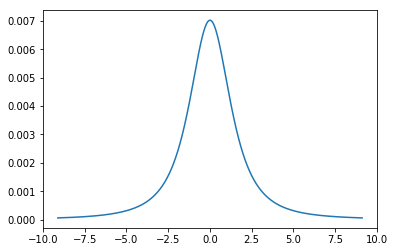

In [6]:
holes = False #set to true if you want to include holes in your simulation
inhomo = True #do you want inhomogneous broadening

f = np.linspace(-gammaq/2, gammaq/2, nbins )
pdf = tsallis(f, q, gammaq/2/np.pi)


if holes:
    frequency_exclude = gcoll/2/np.pi
    exclude_width = 0.2 #FWHM

    indf, freq = find_nearest(f, frequency_exclude)
    scale = pdf[indf]

    toex = cauchy(f, frequency_exclude, exclude_width, -scale)+cauchy(f, -frequency_exclude, exclude_width, -scale)
    #toex2 = cauchy(f, 0, exclude_width, -pdf[int(len(f)/2)])
    pdf = pdf+toex

pdf = np.clip(pdf, 0, max(pdf) )   
    
spdf = sum(pdf)
pdf = pdf/spdf    

if not inhomo:
    pdf = np.zeros(np.shape(pdf))
    pdf[int(nbins/2)] = 1
    
spins = f #draw samples according to distribution
gs = np.sqrt(pdf)*gcoll
plt.plot(f, pdf)


In [7]:
def func(a, eta, deltdrive):
    spins2 = 2*np.pi*(spins)+deltdrive
    sn = a*gs**2*gpar*(gperp-1j*spins2 )
    sd = gpar*gperp**2+4*np.abs(a)**2*gs**2*gperp+gpar*spins2**2
    s = sn/sd
    
    ret = 1j*a*deltdrive + eta + a*kappa + np.sum(s)
    return ret.real, ret.imag

def a_steady(eta, deltadrive, init):

    def equations(x):
        ar, ai = x
        return func(ar+1j*ai, eta, deltadrive)
    ar, ai = fsolve(equations, init)

    return ar, ai

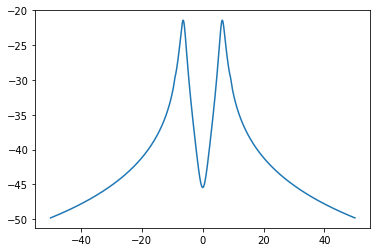

In [8]:
initsteady = (0.1,0.1)
fstart = 50
deltaarr = np.linspace(-fstart*2*np.pi,fstart*2*np.pi, 2000)
etasteady = 0.00001
losasteady = np.zeros(np.shape(deltaarr))
losareal = np.zeros(np.shape(deltaarr))
losaimag = np.zeros(np.shape(deltaarr))

newinit = initsteady
for i, delt in enumerate(deltaarr):
    ar, ai = a_steady(etasteady, delt, newinit)
    newinit = (ar, ai)
    losasteady[i] = ai**2+ar**2
    losareal[i] = ar
    losaimag[i] = ai

fig = plt.figure()
plt.plot(deltaarr/2/np.pi, 10*np.log10(losasteady/0.0000000001))
#deltaarr[find(losasteady == max(losasteady))]/2/pi

In [9]:
#this is as optimized as possible using numpy slicing so calling this function SHOULD be very fast
ret = np.zeros(nbins*2+1, dtype=complex)

#@jit
def mbes(Y, t, eta):
    ret[0] = -kappa*Y[0]-1j*deltac*Y[0]+np.sum(gs*Y[1::2])+eta
    ret[1::2] = -(gperp+1j*spins*2*np.pi)*Y[1::2]+gs*Y[2::2]*Y[0]
    ret[2::2] = -gpar*(1+Y[2::2])-2*gs*(Y[1::2]*np.conj(Y[0])+np.conj(Y[1::2])*Y[0])
    return ret

#%%timeit gives
#10000 loops, best of 3: 45 µs per loop
#for 800 spins it becomes ~70µs. This is probably not the bottleneck


#this function is a lot slower, so be careful when using it
#@jit
def mbes_soc(Y, t, ilist, qlist, tlist):
    idx = find_nearest_sorted(tlist, t)
    ret[0] = -kappa*Y[0]-1j*deltac*Y[0]+np.sum(gs*Y[1::2])+ilist[idx]+1j*qlist[idx]
    ret[1::2] = -(gperp+1j*spins*2*np.pi)*Y[1::2]+gs*Y[2::2]*Y[0]
    ret[2::2] = -gpar*(1+Y[2::2])-2*gs*(Y[1::2]*np.conj(Y[0])+np.conj(Y[1::2])*Y[0])
    return ret


In [10]:
def do_calculation(drive, tlistpump, tlistafter, init):

    #this should be very fast as well because scipy uses fortran 
    asolpump, infodict = odeintz(mbes, init, tlistpump, args=(drive,), full_output=True)
    init2 = asolpump[-1,:]
    asoldecay = odeintz(mbes, init2, tlistafter, args=(0,))
    
    #this is necessary because we are clustering the spins
    asolpump[:,2::2] = asolpump[:,2::2]*pdf
    asolpump[:,1::2] = asolpump[:,1::2]*pdf
    asoldecay[:,2::2] = asoldecay[:,2::2]*pdf
    asoldecay[:,1::2] = asoldecay[:,1::2]*pdf
    return asolpump, asoldecay, infodict
    #solution is that the first entry is the cavity, and then the first spin (sigma-, sigmaz) then the second etc...
    
def do_calculation_stimulated(drivepump, driveprobe, tlistpump, tlistwait, tlistprobe, tlistafter, init):
    #this should be very fast as well because scipy uses fortran 
    asolpump, infodict = odeintz(mbes, init, tlistpump, args=(drivepump,), full_output=True)
    init2 = asolpump[-1,:]
    asolwait = odeintz(mbes, init2, tlistwait, args=(0,))
    init3 = asolwait[-1,:]
    asolprobe = odeintz(mbes, init3, tlistprobe, args=(driveprobe,))
    init4 = asolprobe[-1,:]
    asoldecay = odeintz(mbes, init4, tlistafter, args=(0,))
    
    #this is necessary because we are clustering the spins
    asolpump[:,2::2] = asolpump[:,2::2]*pdf
    asolpump[:,1::2] = asolpump[:,1::2]*pdf
    asoldecay[:,2::2] = asoldecay[:,2::2]*pdf
    asoldecay[:,1::2] = asoldecay[:,1::2]*pdf
    asolwait[:, 2::2] = asolwait[:, 2::2]*pdf
    asolwait[:, 1::2] = asolwait[:, 1::2]*pdf
    asolprobe[:, 1::2] = asolprobe[:, 1::2]*pdf
    asolprobe[:, 2::2] = asolprobe[:, 2::2]*pdf
    return asolpump, asolwait, asolprobe, asoldecay, infodict
    
def do_calculation_soc(ilist, qlist, tlistpump, tlistafter, init):
    """this method is if you want to use shaped drive, which means that the drive-lists as i and q channels
    shape should be given as first arguments
    
    factor is the number by which one has to multiply tlistpump, to get a all integer list as 0,1,2,3...numsteps-1
    """
    #this should be very fast as well because scipy uses fortran 
    asolpump, infodict = odeintz(mbes_soc, init, tlistpump, args=(ilist, qlist, tlistpump), full_output=True)
    init2 = asolpump[-1,:]
    asoldecay = odeintz(mbes, init2, tlistafter, args=(0,))

    asolpump[:,2::2] = asolpump[:,2::2]*pdf
    asolpump[:,1::2] = asolpump[:,1::2]*pdf
    asoldecay[:,2::2] = asoldecay[:,2::2]*pdf
    asoldecay[:,1::2] = asoldecay[:,1::2]*pdf
    
    return asolpump, asoldecay, infodict
    #solution is that the first entry is the cavity, and then the first spin (sigma-, sigmaz) then the second etc...
    
def do_calculation_soc_pump_only(ilist, qlist, tlist, init):
    """this method is if you want to use shaped drive, which means that the drive-lists as i and q channels
    shape should be given as first arguments
    
    it doesn't use a decay afterwards such that it is better for genetic algorithm
    
    factor is the number by which one has to multiply tlistpump, to get a all integer list as 0,1,2,3...numsteps-1
    """
    #this should be very fast as well because scipy uses fortran
    asol, infodict = odeintz(mbes_soc, init, tlist, args=(ilist, qlist, tlist), full_output=True)
    
    asol[:,2::2] = asol[:,2::2]*pdf
    asol[:,1::2] = asol[:,1::2]*pdf
    
    return asol, infodict
    #solution is that the first entry is the cavity, and then the first spin (sigma-, sigmaz) then the second etc...

In [11]:
pumptime = 200e-3
endtime = 600e-3
drive =2382
dt = 0.5e-3

numsteps = 1000

tp = np.arange(0, pumptime, dt)#np.linspace(0,pumptime,numsteps)
tdec = np.arange(pumptime, endtime, dt)#np.linspace(pumptime, endtime, numsteps)

#starting with all spins down
init = np.ones(nbins*2+1)*(-1)
init[0] = 0
init[1::2] = 0

#asolpump, asoldecay, infodict = do_calculation(drive, tp, tdec, init)

Text(0,0.5,'$S_z$')

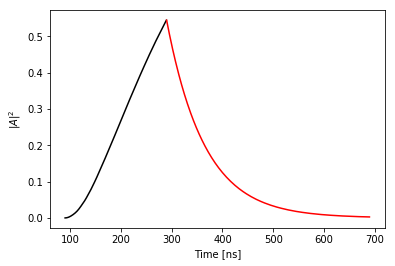

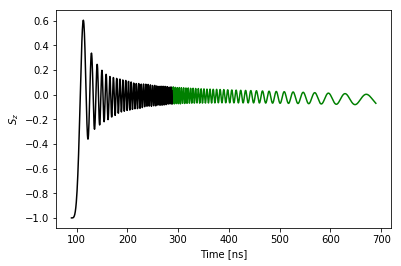

In [12]:
#data = scipy.io.loadmat('/mnt/measure/2016/20170102_MeasurementRun99/3D_H1b/Copy_of_20170228_1900_PowerScan60ns_2Ensmbles/tofit.mat')

#amplexp = data['id'][:,0]**2+data['qd'][:,0]**2
#texp = data['td'][0,:]

plt.figure()
#plt.plot(texp, amplexp)
asolpump, asoldecay, infodict = do_calculation(drive, tp, tdec, init)

scale = 8e-6#1e2
tshift = 90

plt.plot(tp*1000+tshift, scale*abs(asolpump[:,0])**2, 'k-')
plt.plot(tdec*1000+tshift, scale*abs(asoldecay[:,0])**2, 'r-')
plt.xlabel('Time [ns]')
plt.ylabel('$|A|^2$')

if inhomo:
    plt.figure()
    plt.plot(tp*1000+tshift, np.real(np.sum(asolpump[:, 2::2], axis=1)), 'k-')
    plt.plot(tdec*1000+tshift, np.real(np.sum(asoldecay[:, 2::2], axis=1)), 'g-')
else:
    plt.figure()
    plt.plot(tp*1000+tshift, np.real(asolpump[:, 2::2][:, int(nbins/2)]), 'k-')
    plt.plot(tdec*1000+tshift, np.real(asoldecay[:, 2::2][:, int(nbins/2)]), 'g-')
plt.xlabel('Time [ns]')
plt.ylabel('$S_z$')

Text(0,0.5,'$S_-$')

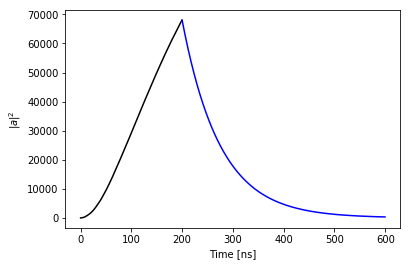

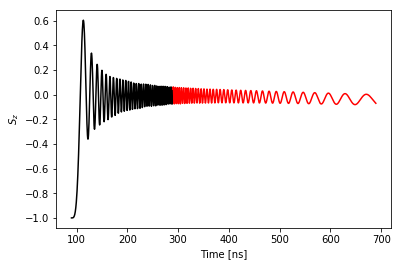

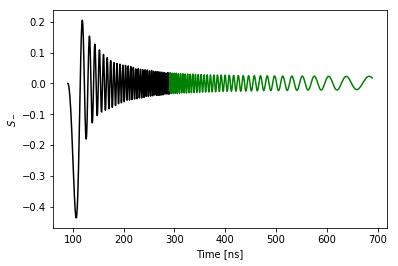

In [13]:
fig1 = plt.figure()
plt.plot(tp*1000, abs(asolpump[:,0])**2, 'k-')
plt.plot(tdec*1000, abs(asoldecay[:,0])**2, 'b-')
plt.xlabel('Time [ns]')
plt.ylabel('$|a|^2$')
#py.iplot_mpl(fig1)
fig2 = plt.figure()
plt.plot(tp*1000+tshift, np.real(np.sum(asolpump[:, 2::2], axis=1)), 'k-')
plt.plot(tdec*1000+tshift, np.real(np.sum(asoldecay[:, 2::2], axis=1)), 'r-')
plt.xlabel('Time [ns]')
plt.ylabel('$S_z$')
#py.iplot_mpl(fig2)
fig3 = plt.figure()
plt.plot(tp*1000+tshift, np.real(np.sum(asolpump[:, 1::2], axis=1)), 'k-')
plt.plot(tdec*1000+tshift, np.real(np.sum(asoldecay[:, 1::2], axis=1)), 'g-')
plt.xlabel('Time [ns]')
plt.ylabel('$S_-$')
#py.iplot_mpl(fig3)

In [21]:
#tlistpump, asolpump, tlistafter, asoldecay = do_calculation(pumptime, endtime, drive)
drive = 1000
pumptime = 50e-3



tall = np.arange(0, endtime, dt)

powdb = np.arange(-20, 0.1, 0.5)

drivelist =(10**(powdb/20))*drive #np.linspace(0, drive, 100)
pumptimelist = np.arange(20e-3, pumptime, dt)


pulselength = False #change if you want to simulate different pulselengths / drive powers

p = qutip.ipynbtools.HTMLProgressBar()
if pulselength:
    p.start(iterations=len(pumptimelist))
    p.N = len(pumptimelist)
    los = np.zeros((len(pumptimelist), len(tall), 3), dtype=np.complex128)
    for i, pl in enumerate(pumptimelist):
        tp = tall[:int(np.ceil(pl/endtime*len(tall)))]
        tdec = tall[int(np.ceil(pl/endtime*len(tall))):]
        losp, losdec, infodict = do_calculation(drive, tp, tdec, init)
        # i can for now only keep the collective operators otherwise I don't have enough RAM
        los[i,:len(tp), 0] = losp[:,0]
        los[i,len(tp):, 0] = losdec[:,0]
        los[i,:len(tp),1] = np.sum(losp[:, 1::2], axis=1)
        los[i,len(tp):,1] = np.sum(losdec[:, 1::2], axis=1)
        los[i,:len(tp),2] = np.sum(losp[:, 2::2], axis=1)
        los[i,len(tp):,2] = np.sum(losdec[:, 2::2], axis=1)
        p.update(i)
    p.finished()

else:
    p.start(iterations=len(drivelist))
    p.N = len(drivelist)
    los = np.zeros((len(drivelist), len(tall), 3), dtype=np.complex128)
    for i, dri in enumerate(drivelist):
        tp = tall[:int(np.ceil(pumptime/endtime*len(tall)))]
        tdec = tall[int(np.ceil(pumptime/endtime*len(tall))):]
        losp, losdec, infodict = do_calculation(dri, tp, tdec, init)
        # i can for now only keep the collective operators otherwise I don't have enough RAM
        los[i,:len(tp), 0] = losp[:,0]
        los[i,len(tp):, 0] = losdec[:,0]
        los[i,:len(tp),1] = np.sum(losp[:, 1::2], axis=1)
        los[i,len(tp):,1] = np.sum(losdec[:, 1::2], axis=1)
        los[i,:len(tp),2] = np.sum(losp[:, 2::2], axis=1)
        los[i,len(tp):,2] = np.sum(losdec[:, 2::2], axis=1)
        p.update(i)
    p.finished()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-14.0
13.69374129317387
111.5
23.125654802637012
21.363225141179946


/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:492: ComplexWarning:

Casting complex values to real discards the imaginary part



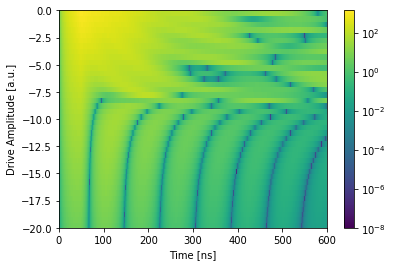

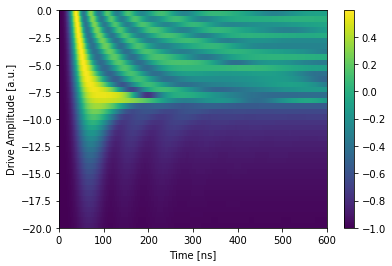

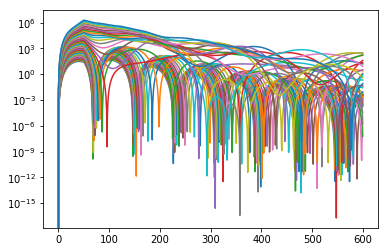

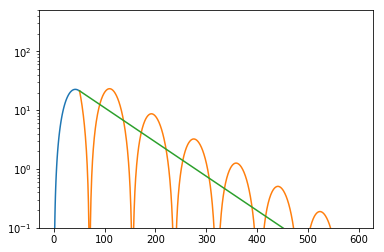

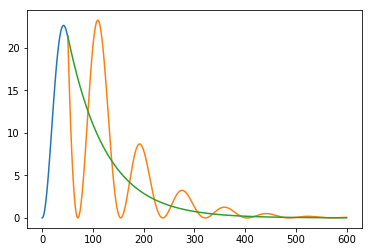

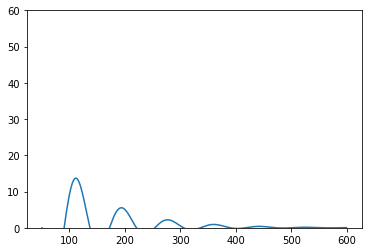

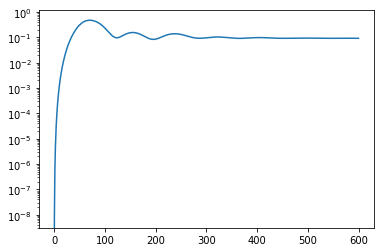

In [22]:
cavampl = abs(los[:, :, 0])**2
amplre = los[:,:,0].real
amplim = los[:,:,0].imag
szall = np.squeeze(los[:, :, 2])
plt.figure()
if pulselength:
    plt.pcolor(tall*1000, pumptimelist*1000, cavampl)
    plt.ylabel('PulseLength [ns]')
else:
    plt.pcolor(tall*1000, powdb, cavampl, norm=LogNorm(vmin=1e-8, vmax=cavampl.max()))
    plt.ylabel('Drive Amplitude [a.u.]')
plt.colorbar()
plt.xlabel('Time [ns]')


plt.figure()
plt.xlabel('Time [ns]')
if pulselength:
    plt.pcolor(tall*1000, pumptimelist*1000, los[:,:,2].real)
    plt.ylabel('PulseLength [ns]')
else:
    plt.pcolor(tall*1000, powdb, los[:,:,2].real)
    plt.ylabel('Drive Amplitude [a.u.]')

plt.colorbar()
ind =12
plt.figure()
for i in range(0, len(drivelist)):
    plt.semilogy(tall*1000, abs(cavampl[i,:])**2)

plt.figure()
print(powdb[ind])
#plt.semilogy(tall*1000, 1+los[ind, : ,2])
nphotons = abs(los[ind, len(tp): ,0])**2
plt.semilogy(tp*1000, abs(los[ind, :len(tp), 0])**2)
plt.semilogy(tdec*1000, nphotons)# - nphotons[0]*np.exp(-2*kappa*(tdec-tdec[0])))
plt.semilogy(tdec*1000, nphotons[0]*np.exp(-2*kappa*(tdec-tdec[0])))
plt.ylim([10e-2, 500])

plt.figure()
#plt.semilogy(tall*1000, 1+los[ind, : ,2])
nphotons = abs(los[ind, len(tp): ,0])**2
plt.plot(tp*1000, abs(los[ind, :len(tp), 0])**2)
plt.plot(tdec*1000, nphotons)# - nphotons[0]*np.exp(-2*kappa*(tdec-tdec[0])))
plt.plot(tdec*1000, nphotons[0]*np.exp(-2*kappa*(tdec-tdec[0])))
#plt.ylim([10e-2, 500])


plt.figure()
plt.plot(tdec*1000, nphotons- nphotons[0]*np.exp(-2*kappa*(tdec-tdec[0])))
plt.ylim([0, 60])
print(max(nphotons- nphotons[0]*np.exp(-2*kappa*(tdec-tdec[0]))))
indi, valu = find_nearest(nphotons- nphotons[0]*np.exp(-2*kappa*(tdec-tdec[0])), max(nphotons- nphotons[0]*np.exp(-2*kappa*(tdec-tdec[0]))))
print(tdec[indi]*1000)
print(nphotons[indi])
print(nphotons[0])

plt.figure()
plt.semilogy(tall*1000, 1+los[ind, : ,2])
#plt.plot(tall*1000, los[ind, :,2])
#plt.ylim([10e-2, 500])
data = {
    'amplre': amplre, 
    'drive': drive,
    'amplim':amplim,
    'gcoll': gcoll, 'q': q, 'quali': quali, 'freq': fr, 'kappa':kappa, 'gperp':gperp, 
    'gpar':gpar, 'gammaq': gammaq, 'nbins':nbins, 
    'szall': szall, 'power': powdb, 't': tall, 'tpump':tp, 'tdec': tdec, 'a2':nphotons}

Text(0,0.5,'$S_z$')

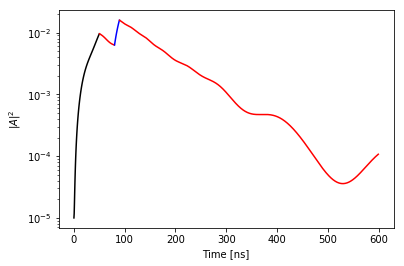

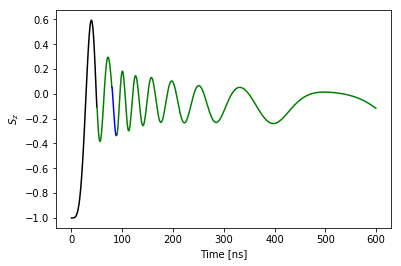

In [20]:
dr = drivelist[-9]
driveprobe = dr*1e-1*20
plt.figure()

waittime = 30e-9*1e6
probetime = 10e-9*1e6

indafterpump = int(np.ceil(pumptime/endtime*len(tall)))
indafterwait = int(np.ceil((waittime + pumptime)/endtime*len(tall)))
indafterprobe = int(np.ceil((probetime + waittime + pumptime)/endtime*len(tall)))

tp2 = tall[:indafterpump]
tw = tall[indafterpump:indafterwait]
tprobe = tall[indafterwait:indafterprobe]
tdec2 = tall[indafterprobe:]

#plt.plot(texp, amplexp)
asolpump, asolwait, asolprobe, asoldecay, infodict = do_calculation_stimulated(dr, driveprobe, tp2, tw, tprobe, tdec2, init)

scale = 8e-6#1e2
tshift = 90

plt.semilogy(tp2*1000, 0.00001+scale*abs(asolpump[:,0])**2, 'k-')
plt.plot(tw*1000,  0.00001+scale*abs(asolwait[:,0])**2, 'r-')
plt.plot(tprobe*1000,  0.00001+scale*abs(asolprobe[:,0])**2, 'b-')
plt.plot(tdec2*1000,  0.00001+scale*abs(asoldecay[:,0])**2, 'r-')
plt.xlabel('Time [ns]')
plt.ylabel('$|A|^2$')

if inhomo:
    plt.figure()
    plt.plot(tp2*1000, np.real(np.sum(asolpump[:, 2::2], axis=1)), 'k-')
    plt.plot(tw*1000,  np.real(np.sum(asolwait[:, 2::2], axis=1)), 'g-')
    plt.plot(tprobe*1000,  np.real(np.sum(asolprobe[:, 2::2], axis=1)), 'b-')
    plt.plot(tdec2*1000, np.real(np.sum(asoldecay[:, 2::2], axis=1)), 'g-')
else:
    plt.figure()
    plt.plot(tp2*1000, np.real(asolpump[:, 2::2][:, int(nbins/2)]), 'k-')
    plt.plot(tw*1000,  np.real(np.sum(asolwait[:, 2::2][:, int(nbins/2)], axis=1)), 'g-')
    plt.plot(tprobe*1000,  np.real(np.sum(asolprobe[:, 2::2][:, int(nbins/2)], axis=1)), 'b-')
    plt.plot(tdec2*1000, np.real(asoldecay[:, 2::2][:, int(nbins/2)]), 'g-')
plt.xlabel('Time [ns]')
plt.ylabel('$S_z$')

#SOC pulses

In [12]:
def pulse_rwa(t, args):
    ampl = args[-1]
    wgrund = args[0]
    fcomps = args[1][0,:]
    pulseI = 0
    for i in range(len(fcomps)):
        pulseI = pulseI+(fcomps[i])*np.sin((i+1)*wgrund*t)
    return pulseI


def pulse_rwa_conv(t, args):
    wgrund = args[0]
    fcomps = args[1][0,:]
    kappa = args[2]
    probe_detuning = args[3]
    pulse = 0
    for i in range(len(fcomps)):
        f = (i+1)*wgrund
        pulse = pulse+(fcomps[i])*np.sin(f*t)
    impulse_response = np.exp(-t*(kappa-1j*probe_detuning))*kappa
    fixed, remainder = signal.deconvolve(np.hstack((pulse, np.zeros(len(pulse)-1))), impulse_response)
    return fixed


def pulse_rwa_q_conv(t, args):
    wgrund = args[0]
    fcomps = args[1][1,:]
    kappa = args[2]
    probe_detuning = args[3]
    pulse = 0
    for i in range(len(fcomps)):
        f = (i+1)*wgrund
        pulse = pulse+(fcomps[i])*np.sin(f*t)

    impulse_response = np.exp(-t*(kappa-1j*probe_detuning))*kappa
    fixed, remainder = signal.deconvolve(np.hstack((pulse, np.zeros(len(pulse)-1))), impulse_response)
    return fixed


def pulse_rwa_q(t, args):
    wgrund = args[0]
    fcomps = args[1][1,:]
    pulseQ = 0
    for i in range(len(fcomps)):
        pulseQ = pulseQ+(fcomps[i])*np.sin((i+1)*wgrund*t)
    return pulseQ
%qtconsole

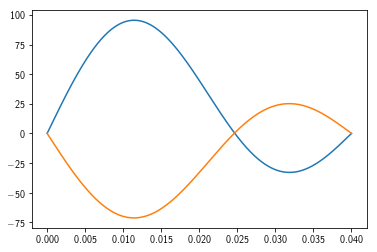

In [11]:
pumptime = 40e-3
endtime = 200e-3
drive = 10000



tlist = np.linspace(0,pumptime,10000)
wgrund = np.pi/tlist[-1]
fourier_comps = np.array([[0.5681774749, 0.7919859859],
                       [-0.4196001076, -0.5953895567]])*np.pi/tlist[-1]
#fourier_comps = np.array([[-0.0099837803, -0.4185502108, 1.6353487476, 2.2966138065, 0.5682391145, -2.2598190816]
#                      ,[1.0448206858, 0.7446281278, -0.1102186624, -3.3312204644, 1.145149641, 3.1822915747]
#                      ])*np.pi/tlist[-1]

bp = pulse_rwa(tlist, [wgrund, fourier_comps])
ep = pulse_rwa_q(tlist, [wgrund, fourier_comps])

pulseq = pulse_rwa_q_conv(tlist, [wgrund, fourier_comps, kappa, deltac])
pulsei = pulse_rwa_conv(tlist, [wgrund, fourier_comps, kappa, deltac])

pulseq = pulseq/max(abs(pulseq))*max(abs(ep))
pulsei = pulsei/max(abs(pulsei))*max(abs(bp))

maxi = max(max(abs(pulsei)), max(abs(pulsei)))

pulseq = pulseq/maxi
pulsei = pulsei/maxi

pulseq = pulseq.real
pulsei = pulsei.real

plt.figure()
plt.plot(tlist, bp)
plt.plot(tlist, ep)

In [400]:
tlistreal = tlist

tp = np.linspace(0,pumptime,numsteps)
tdec = np.linspace(pumptime, endtime, numsteps)

#starting with all spins down
init = np.ones(nbins*2+1)*(-1)
init[0] = 0
init[1::2] = 0

asolpump, asoldecay, infodict = do_calculation_soc(pulsei*drive, pulseq*drive, tp, tdec, init)

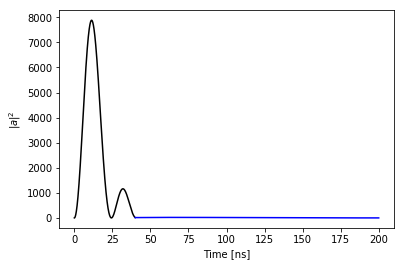

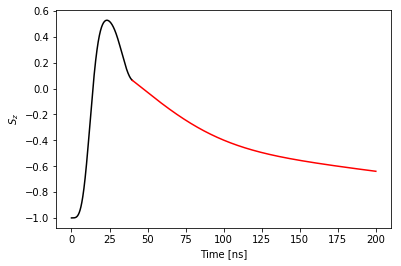

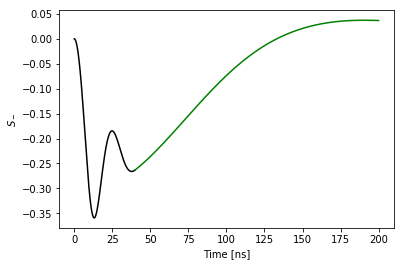

In [401]:
fig1 = plt.figure()
plt.plot(tp*1000, abs(asolpump[:,0])**2, 'k-')
plt.plot(tdec*1000, abs(asoldecay[:,0])**2, 'b-')
plt.xlabel('Time [ns]')
plt.ylabel('$|a|^2$')
#py.iplot_mpl(fig1)
fig2 = plt.figure()
plt.plot(tp*1000, np.real(np.sum(asolpump[:, 2::2], axis=1)), 'k-')
plt.plot(tdec*1000, np.real(np.sum(asoldecay[:, 2::2], axis=1)), 'r-')
plt.xlabel('Time [ns]')
plt.ylabel('$S_z$')
#py.iplot_mpl(fig2)
fig3 = plt.figure()
plt.plot(tp*1000, np.real(np.sum(asolpump[:, 1::2], axis=1)), 'k-')
plt.plot(tdec*1000, np.real(np.sum(asoldecay[:, 1::2], axis=1)), 'g-')
plt.xlabel('Time [ns]')
plt.ylabel('$S_-$')
#py.iplot_mpl(fig3)

In [ ]:
#tlistpump, asolpump, tlistafter, asoldecay = do_calculation(pumptime, endtime, drive)
drive = 8000
pumptime = 200e-3
numsteps = 20000

tlistreal = tlist

tall = np.linspace(0, endtime, numsteps)


drivelist = np.linspace(0, drive, 100)
pumptimelist = np.linspace(40e-3, pumptime, 60)


pulselength = True #change if you want to simulate different pulselengths / drive powers

p = qutip.ipynbtools.HTMLProgressBar()
if pulselength:
    p.start(iterations=len(pumptimelist))
    p.N = len(pumptimelist)
    los = np.zeros((len(pumptimelist), numsteps, 3), dtype=np.complex128)
    for i, pl in enumerate(pumptimelist):
        tp = tall[:int(np.ceil(pl/endtime*numsteps))]
        tdec = tall[int(np.ceil(pl/endtime*numsteps)):]
        losp, losdec, infodict = do_calculation_soc(pulsei*drive, pulseq*drive, tp, tdec, init)
        # i can for now only keep the collective operators otherwise I don't have enough RAM
        los[i,:len(tp), 0] = losp[:,0]
        los[i,len(tp):, 0] = losdec[:,0]
        los[i,:len(tp),1] = np.sum(losp[:, 1::2], axis=1)
        los[i,len(tp):,1] = np.sum(losdec[:, 1::2], axis=1)
        los[i,:len(tp),2] = np.sum(losp[:, 2::2], axis=1)
        los[i,len(tp):,2] = np.sum(losdec[:, 2::2], axis=1)
        p.update(i)
    p.finished()

else:
    p.start(iterations=len(drivelist))
    p.N = len(drivelist)
    los = np.zeros((len(drivelist), numsteps, 3), dtype=np.complex128)
    for i, dri in enumerate(drivelist):
        tp = tall[:int(np.ceil(pumptime/endtime*numsteps))]
        tdec = tall[int(np.ceil(pumptime/endtime*numsteps)):]
        losp, losdec, infodict = do_calculation_soc(pulsei*drive, pulseq*drive, tp, tdec, init)
        # i can for now only keep the collective operators otherwise I don't have enough RAM
        los[i,:len(tp), 0] = losp[:,0]
        los[i,len(tp):, 0] = losdec[:,0]
        los[i,:len(tp),1] = np.sum(losp[:, 1::2], axis=1)
        los[i,len(tp):,1] = np.sum(losdec[:, 1::2], axis=1)
        los[i,:len(tp),2] = np.sum(losp[:, 2::2], axis=1)
        los[i,len(tp):,2] = np.sum(losdec[:, 2::2], axis=1)
        p.update(i)
    p.finished()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [ ]:
cavampl = abs(los[:, :, 0])**2


plt.figure()
if pulselength:
    plt.pcolor(tall*1000, pumptimelist*1000, cavampl)
    plt.ylabel('PulseLength [ns]')
else:
    plt.pcolor(tall*1000, drivelist, cavampl)
    plt.ylabel('Drive Amplitude [a.u.]')

#xlabel('Time [ns]')
plt.figure()
plt.xlabel('Time [ns]')
if pulselength:
    plt.pcolor(tall*1000, pumptimelist*1000, los[:,:,2].real)
    plt.ylabel('PulseLength [ns]')
else:
    plt.pcolor(tall*1000, drivelist, los[:,:,2].real)
    plt.ylabel('Drive Amplitude [a.u.]')
plt.colorbar()

ind = 11 
plt.figure()
plt.semilogy(tall*1000, cavampl[ind,:])

plt.figure()
plt.plot(tall*1000, los[ind, : ,2])


In [28]:
import IPython.display as disp
import time

In [31]:
ret = disp.Pretty("test")

In [32]:
h = display(ret)

test

In [33]:
h